# Data Science Bowl 2019

# Introduction

PBS KIDS, a trusted name in early childhood education for decades, aims to gain insights into how media can help children learn important skills for success in school and life. In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education. Competitors will be challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. Your solutions will aid in discovering important relationships between engagement with high-quality educational media and learning processes.

**Where does the data for the competition come from?**
The data used in this competition is anonymous, tabular data of interactions with the PBS KIDS Measure Up! app. Select data, such as a user’s in-app assessment score or their path through the game, is collected by the PBS KIDS Measure Up! app, a game-based learning tool.

**What is the PBS KIDS Measure Up! app?**
In the PBS KIDS Measure Up! app, children ages 3 to 5 learn early STEM concepts focused on length, width, capacity, and weight while going on an adventure through Treetop City, Magma Peak, and Crystal Caves. Joined by their favorite PBS KIDS characters, children can also collect rewards and unlock digital toys as they play. 

Besides the info provided above by Kaggle, I found the following additional info on the website of the app:

Specific features of Measure Up! include:

* 19 unique measuring games.
* 10 measurement-focused video clips.
* Sticker books featuring favorite PBS KIDS characters.
* Rewards for completion of tasks.
* Embedded challenges and reports to help parents and caregivers monitor kids’ progress.
* Ability to track your child's progress using the PBS KIDS Super Vision companion app.

**Evaluation**
Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement than expected by chance, the metric may go below 0.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved



For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

# Table of contents

* [1. Understanding the train data](#1.-Understanding-the-train-data)
* [2. Understanding the test set](#2.-Understanding-the-test-set)
* [3. Understanding and visualizing the train labels](#3.-Understanding-and-visualizing-the train-labels)
* [4. Feature engineering](#4.-Feature-engineering)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import warnings
warnings.filterwarnings("ignore")


import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.model_selection import GroupKFold
from typing import Any
from numba import jit
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from itertools import product
import copy
import time

In [2]:
%%time
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

CPU times: user 1min 14s, sys: 11.1 s, total: 1min 25s
Wall time: 1min 25s


# 1. Understanding the train data

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
train.shape

(11341042, 11)

So we have 11 million rows and just 11 columns. However, Kaggle provided the following note: Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

As there is no point in keeping training data that cannot be used for training anyway, I am getting rid of the installation_ids that never took an assessment
    

In [5]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")

As you can see, we have now lost about 3 million rows.

In [6]:
train.shape

(8294138, 11)

The number of unique installations in our "smaller" train set is now 4242.

In [7]:
keep_id.shape

(4242, 1)

I will first visualize some of the existing columns.

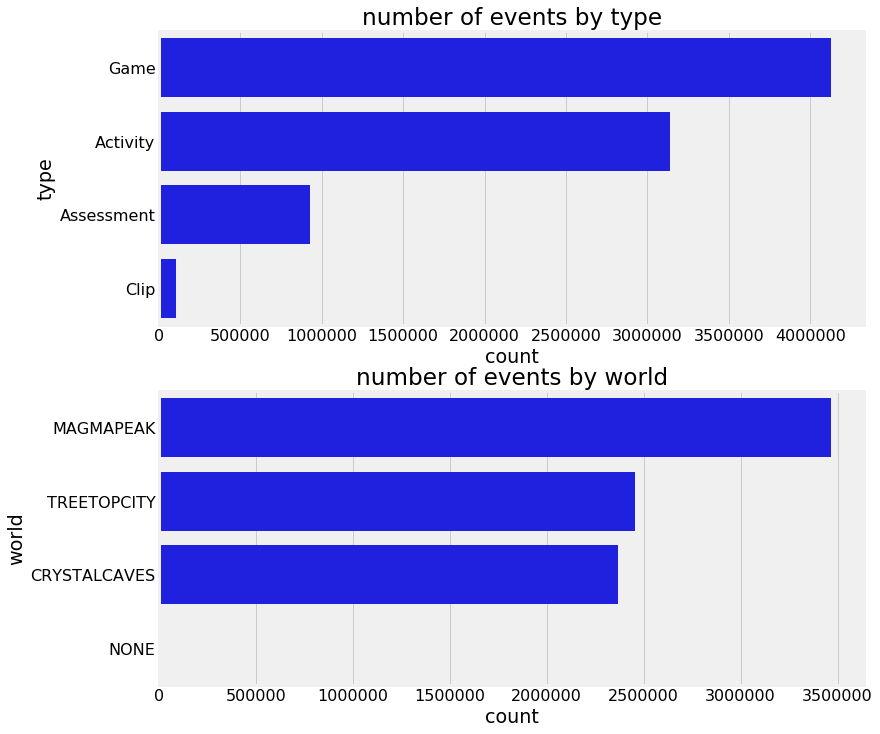

In [8]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax1 = sns.countplot(y="type", data=train, color="blue", order = train.type.value_counts().index)
plt.title("number of events by type")

ax2 = fig.add_subplot(212)
ax2 = sns.countplot(y="world", data=train, color="blue", order = train.world.value_counts().index)
plt.title("number of events by world")

plt.tight_layout(pad=0)
plt.show()

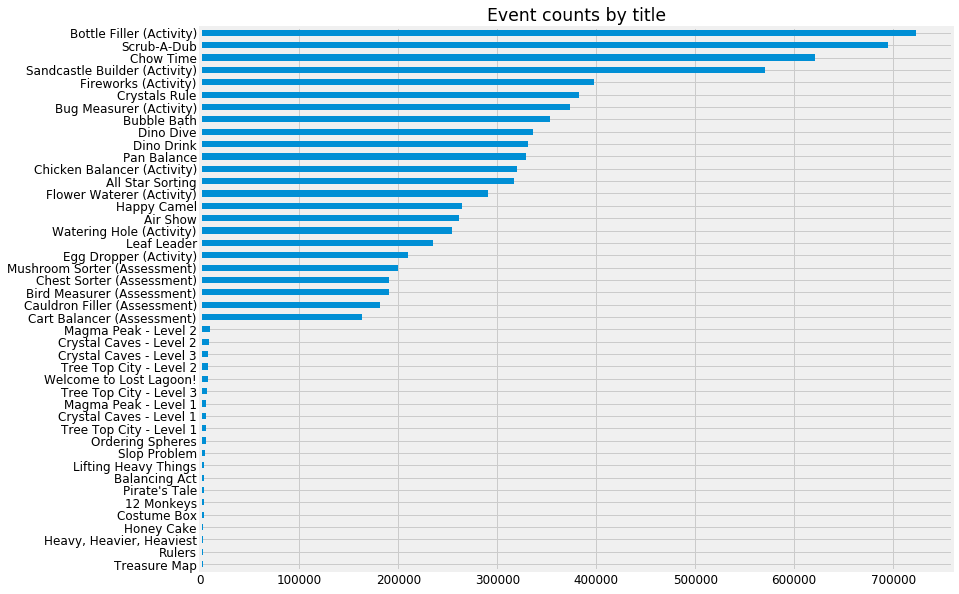

In [9]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12,10))
se = train.title.value_counts().sort_values(ascending=True)
se.plot.barh()
plt.title("Event counts by title")
plt.xticks(rotation=0)
plt.show()

I will now add some new columns based on the timestamp, and visualize these.

In [10]:
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df
    
train = get_time(train)

Below your see the counts by date. By the way, I have wasted a lot of time on trying to fix the weird ticks on the x-axis, but this seems a bug: https://github.com/matplotlib/matplotlib/issues/13183

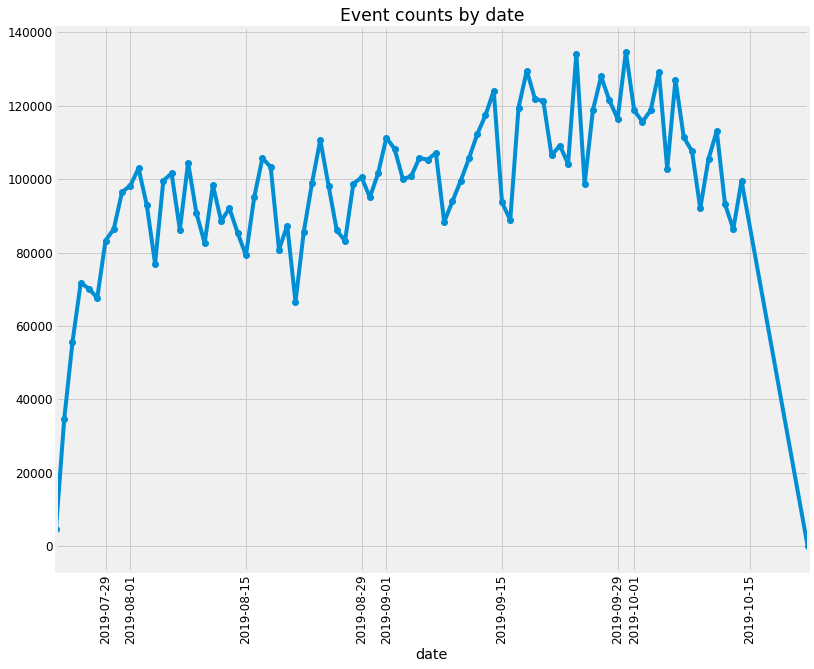

In [11]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('date')['date'].count()
se.plot(style='o-')
plt.title("Event counts by date")
plt.xticks(rotation=90)
plt.show()

When looking at the day of the week, we see no major difference. Of course, we are talking about kids who don't have to go to work ;-)

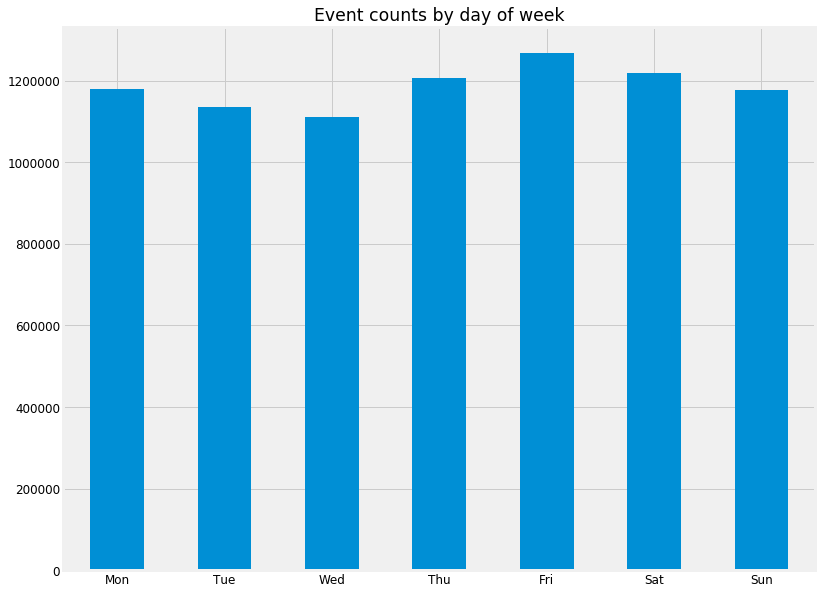

In [12]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('dayofweek')['dayofweek'].count()
se.index = list(calendar.day_abbr)
se.plot.bar()
plt.title("Event counts by day of week")
plt.xticks(rotation=0)
plt.show()

When looking at the numbers by hour of the day, I find the distribution a little bit strange. Kids seem up late at night and don't do much early in the morning. Has this something to do with time zones perhaps?

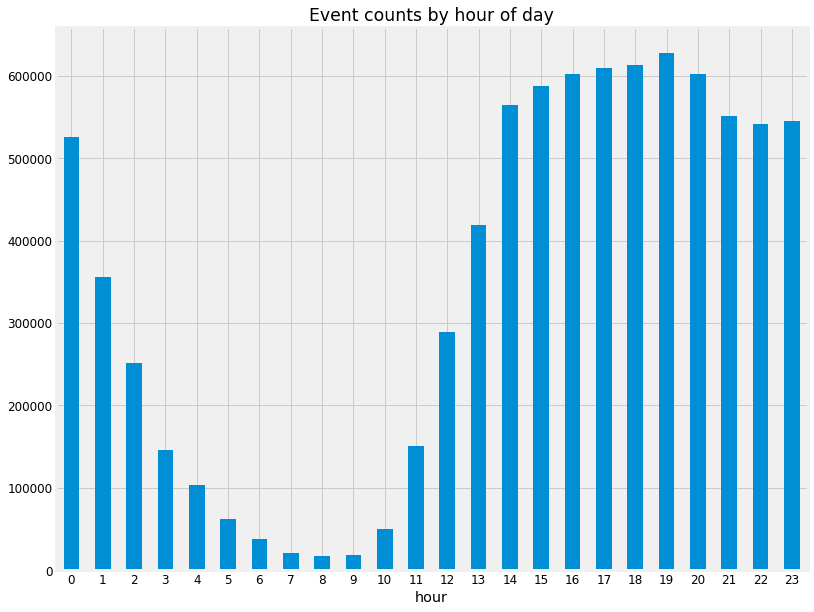

In [13]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('hour')['hour'].count()
se.plot.bar()
plt.title("Event counts by hour of day")
plt.xticks(rotation=0)
plt.show()

# 2. Understanding the test set

From Kaggle: For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

In [14]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [15]:
test.shape

(1156414, 11)

In [16]:
test.installation_id.nunique()

1000

So we have 1.1 million rows on a thousand unique installation_ids in the test set. Below, you can see that we have this same amount of rows in the sample submission. This means that there are no installation_ids without assessment in the test set indeed.

In [17]:
sample_submission.shape[0]

1000

Another thing that I would like to check is if there is any overlap with regards to installation_id's in the train and test set. As you can see, there are no installation_id's that appear in both train and test.

In [18]:
set(list(train.installation_id.unique())).intersection(set(list(test.installation_id.unique())))

set()

What about the date ranges?

In [19]:
test['timestamp'] = pd.to_datetime(test['timestamp'])
print(f'The date range in train is: {train.timestamp.dt.date.min()} to {train.timestamp.dt.date.max()}')
print(f'The date range in test is: {test.timestamp.dt.date.min()} to {test.timestamp.dt.date.max()}')

The date range in train is: 2019-07-23 to 2019-10-22
The date range in test is: 2019-07-24 to 2019-10-14


The date range is more or less the same, so we are talking about a dataset that seems (randomly) split on installation_id. Well actually "sort of" as Kaggle seems to have done this on installation_id's with assessments first, and added the "left-overs" with no assessments taken to the train set.
trainからvalidationデータを取り出す時は普通のkfoldでおっけ

# 3. Understanding and visualizing the train labels

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved


I started by visualizing some of these columns

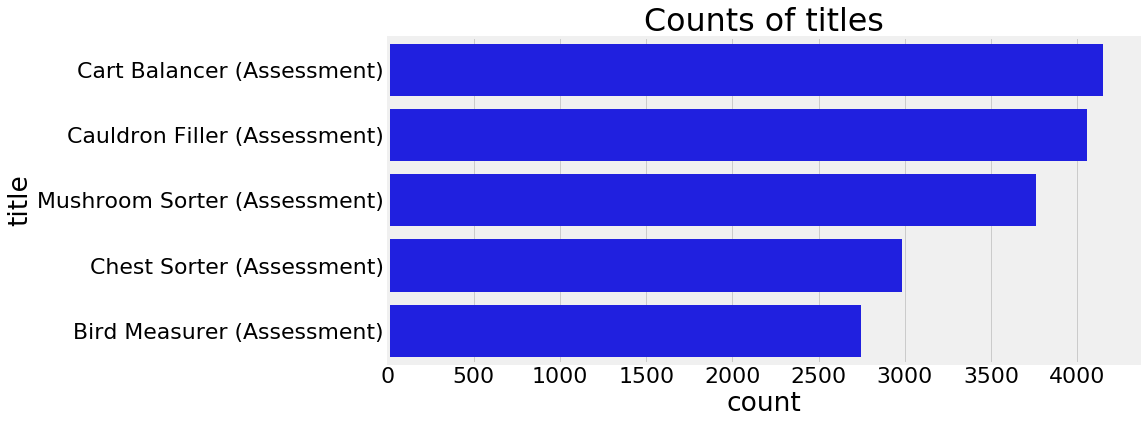

In [20]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12,6))
sns.countplot(y="title", data=train_labels, color="blue", order = train_labels.title.value_counts().index)
plt.title("Counts of titles")
plt.show()

Below, you can see that a lot of Chest Sorter assessments were never solved. Bird Measurer also seems hard with a relatively small amount solved on the first attempt.
ゲームによって難易度が違うっぽいからこの情報は結構大事

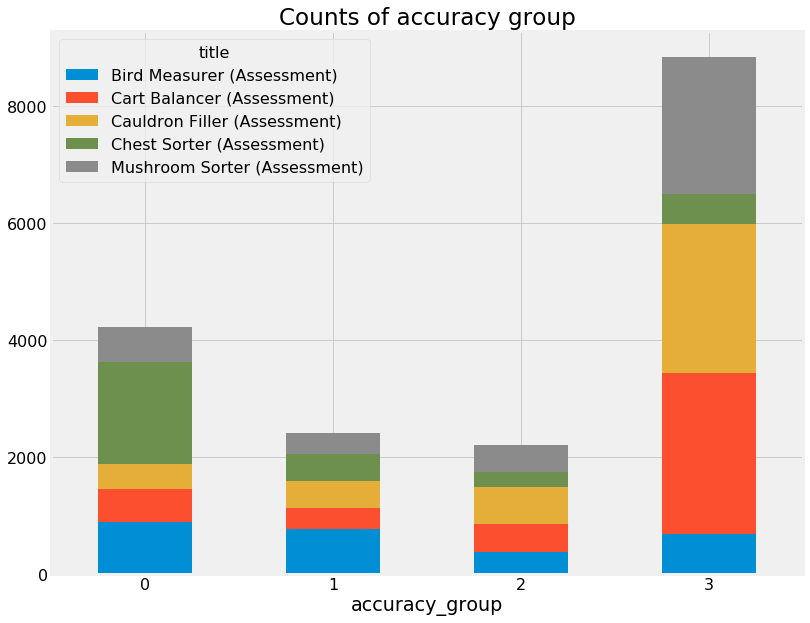

In [21]:
plt.rcParams.update({'font.size': 16})

se = train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')
se.plot.bar(stacked=True, rot=0, figsize=(12,10))
plt.title("Counts of accuracy group")
plt.show()


As the match between the train dataframe and the train_labels dataframe is not straightforward, it tried to figure out how these dataframes are to be matched by focussing on just one particular installation_id.

In [22]:
train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


From Kaggle: The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.
→event_code 4100ってのはAssessmentに対応するコード、Bird Measurerに関してはevent_code 4110、その中にcorrectがtrueとなっていれば成功、そうでなきゃ失敗

However, in the first version I already noticed that I had one attempt too many for this installation_id when mapping the rows with the train_labels for. It turns out that there are in fact also assessment attemps for Bird Measurer with event_code 4100, which should not count (see below). In this case that also makes sense as this installation_id already had a pass on the first attempt(実はevent_codeが4100だけど、Bird Measureのゲームのassessmentが数えられているパターンがあるらしい、以下がそう)

In [23]:
train[(train.event_code == 4100) & (train.installation_id == "0006a69f") & (train.title == "Bird Measurer (Assessment)")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
2615,070a5291,a9ef3ecb3d1acc6a,2019-08-06 20:50:33.283000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",0006a69f,30,4100,34209,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,20,1


When we exclude the Bird Measurer/4100 rows we get the correct match with the numbers in train_labels for this installation_id (4 correct, 12 incorrect)

In [24]:
train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
                                               (train.type == "Assessment") & (train.title != 'Bird Measurer (Assessment)') & (train.event_code == 4100))]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1212,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1


Now the question arises: Could there be installation_id's who did assessments (we have already taken out the ones who never took one), but without results in the train_labels? As you can see below, yes there are 628 of those.
train_labels内にあるindtallation_idの中で、trainに入っていないinstallation_idの数

In [25]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

As we can not train on those installation_id's anyway, I am taking them out of the train set. This reduces our train set further from 8.3 million rows to 7.7 million.

In [26]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 15)

In [27]:
train.head()
# event_dataを取り出して1セッションごとの中の座標とかそういう情報をまとめるのはいいかも

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,8,4,1
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,8,4,1
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1


# 4. Feature engineering

Basically what we need to do is to compose aggregated features for each session of which we know the train label. Before I get started, I am quickly checking if game_session alone is the unique identifier in train_labels indeed.
trainデータのラベルがわかっている奴をsessionごとにうまくまとめることが必要、以下の通りgame_sessionごとにデータをまとめるのが良い

In [28]:
print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


Ok, now that we have that confirmed, I my first step was initially to start by looking for values that are always the same for a game_session in the train dataframe. It turns out that the only one is world. I also checked if some of the datetime variables were unique, but this is not always the case (events within a session may cross midnight).
→まずはgame_session内で定数の値である奴を探す。(それはworldだけ、日付時間に関してもgame_session内で変わることあり)

Of course, on Kaggle it is not always necessary to reinvent the wheel. I knew that I would have to iterate over all the rows and add features that only look at what happened up to the moment at which the an installation_id starts a particluar assessment. I found out that Massoud Hosseinali already posted fantastic code on how to do that in this kernel: https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model. Thanks Massoud, and all credit go to you! As Bruno Aquino reused this code and already added some comments, I am actually using his code.

As I figured out that datetime variables cannot be matched uniquely to the train_labels, I am starting again with a train dataframe as it originally was (except for keeping timestamp as datetime). The huge code chunck below contains the function to generate features for each row in train_labels.

In [29]:
train = train.drop(['date', 'month', 'hour', 'dayofweek'], axis=1)

In [30]:
#Credits go to Andrew Lukyanenko

def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

categoricals = ['session_title']

## 上のコードで取り出したもの
- train→元々のtrainについて、'title', 'wolrd'を数値に置き換えたもの、'timestamp'をdatetime型に直したもの、title(アンダーバー)event_codeで作った新しいカラムtitle_event_codeを追加(pd.DataFrame)
- test→→元々のtestについて、'title', 'wolrd'を数値に置き換えたもの、'timestamp'をdatetime型に直したもの、title(アンダーバー)event_codeで作った新しいカラムtitle_event_codeを追加(pd.DataFrame)
- train_labels→元々のtrain_labelsについて、titleをint型に置き換えたもの(pd.DataFrame)
- win_code→(おそらく)各titleに対応したassessmentのevent_code(dict)
- list_of_user_activities→各titleが入っているリスト(list)
- list_of_event_code→各event_codeが入っているリスト(list)
- activities_labels→各titleと数字の対応がまとめられているもの(dict)
- assess_titles→typeがAsessmentになっている時のtitleのリスト(list)
- list_of_event_id→event_idのリスト(list)
- all_title_event_code→trainとtest合わせたtrain_event_codeのリスト(list)

In [31]:
train

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,title_event_code
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,17,Clip,1,Welcome to Lost Lagoon!_2000
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,39,Clip,3,Magma Peak - Level 1_2000
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,18,Activity,3,Sandcastle Builder (Activity)_2000
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,18,Activity,3,Sandcastle Builder (Activity)_3010
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,18,Activity,3,Sandcastle Builder (Activity)_4070
...,...,...,...,...,...,...,...,...,...,...,...,...
8294133,28520915,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,42,Assessment,3,Cauldron Filler (Assessment)_2030
8294134,91561152,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,42,Assessment,3,Cauldron Filler (Assessment)_4025
8294135,d3268efa,5448d652309a6324,2019-09-22 02:07:27.566000+00:00,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,42,Assessment,3,Cauldron Filler (Assessment)_3021
8294136,b5053438,5448d652309a6324,2019-09-22 02:07:28.311000+00:00,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,42,Assessment,3,Cauldron Filler (Assessment)_3121


In [32]:
temp_df = train.copy()
temp_df = temp_df[temp_df.type == 'Assessment']
temp_df['game_session'].nunique()

20092

In [33]:
#Credits go to Massoud Hosseinali
# あるユーザーについてゲームセッションごとにデータをまとめている。
# ここをいじるとしたら、辞書のやつの処理を検討するしかない

def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title] #from Andrew
        
        # get current session time in seconds
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1] #from Andrew
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        n_of_event_codes = Counter(session['event_code'])
        
        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if test_set=True, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in train_set, all assessments are kept
    return all_assessments

## 取得している特徴量(全てあるユーザーの一つのgame_sessionごとに、合計で103になるはず)
- 1つのゲームセッションでいろんなゲームタイプのアクティビィティが行われる
- 各ゲームタイプ('Clip', 'Activity', 'Assessment', 'Game')の回数(4つ)　N
- Cart Balancer (Assessment)...:各activityにかけた時間、activityはtrain.csvのtitleカラムに相当(44つ) N
- event_codeごとの回数(42つ) N
- installation_id(ユーザーのID) C
- session_title(そのsessionのゲームタイトル) C
- 'accumulated_correct_attempts', 'accumulated_uncorrect_attempts'(これまでの成功失敗の試行回数) N
- duration_mean(そのユーザーのゲームにかけている平均時間) N
- 'accumulated_accuracy'(累積の正解精度) N
- accuracy_group: これは目的変数 C 
- accuracy_groups(0-3それぞれに所属した回数): (4つ) N
- accumulated_accuracy_group: これまで所属したgroupの平均 N
- accumulated_actions: これまでのaction数 N

To make this a little bit easier to understand, I am first using the function on one installation_id as an example (same one as used as an example before). Below, I have only displayed the last bunch of columns of the resulting dataframe. As you can see, five rows have been created for this installation_id.

In [34]:
sample_id = train[train.installation_id == "0006a69f"]
sample_id_data = get_data(sample_id) #returns a list
sample_df = pd.DataFrame(sample_id_data)
sample_df.iloc[:,-10:]

,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,0,0.00,0.0,3,0,0,0,0,0.0,647
1,0,39.00,1.0,0,0,0,0,1,3.0,1143
2,11,65.50,0.5,3,1,0,0,1,1.5,1230
3,11,41.25,0.5,2,2,0,0,2,1.5,2159
4,12,39.20,0.5,3,2,0,1,2,1.6,2586


When we compare this to the train_labels, you can see that the accuracy_group values are the same so features have been added for all game_session id's. However more importantly, by comparing the accumulated_uncorrect_attempts with num_incorrect, you will see that **only activities before the start of that particular session have been accumulated**.

In [35]:
train_labels[train_labels.installation_id == "0006a69f"].iloc[:, [0, 1, -3, -1]]

,game_session,installation_id,num_incorrect,accuracy_group
0,6bdf9623adc94d89,0006a69f,0,3
1,77b8ee947eb84b4e,0006a69f,11,0
2,901acc108f55a5a1,0006a69f,0,3
3,9501794defd84e4d,0006a69f,1,2
4,a9ef3ecb3d1acc6a,0006a69f,0,3


In the code below the function is applied to each installation_id in the train dataset.

Compared to the original code I changed the total. In the original code this was set at 17,000. However, since I reduced the train dataframe, I only have 3614 of those left (train.installation_id.nunique()=3614). In addition, I had issues with incorrect rendering of the tdqm bar, and solved this by adding position=0. I also turns out that possible to add a description, which is nice to have.

In [36]:
#Credits go to Massoud Hosseinali

#The get_data function is applied to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique(), desc='Installation_id', position=0):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

In [37]:
#Credits go to Massoud Hosseinali

#Compiled_data is converted into a DataFrame and deleted to save memmory
reduce_train = pd.DataFrame(compiled_data)
del compiled_data
reduce_train.shape

(17690, 103)

In [38]:
reduce_train.head()

,Clip,Activity,Assessment,Game,Pan Balance,Rulers,Ordering Spheres,12 Monkeys,Tree Top City - Level 2,Bubble Bath,Crystal Caves - Level 2,Leaf Leader,Bird Measurer (Assessment),"Heavy, Heavier, Heaviest",Treasure Map,Bug Measurer (Activity),Lifting Heavy Things,Honey Cake,Balancing Act,Egg Dropper (Activity),Cart Balancer (Assessment),Welcome to Lost Lagoon!,Sandcastle Builder (Activity),Dino Dive,Mushroom Sorter (Assessment),Crystals Rule,Costume Box,Slop Problem,Pirate's Tale,Fireworks (Activity),Crystal Caves - Level 3,Chest Sorter (Assessment),Watering Hole (Activity),Magma Peak - Level 2,Bottle Filler (Activity),Scrub-A-Dub,Tree Top City - Level 1,Air Show,Crystal Caves - Level 1,Dino Drink,Chicken Balancer (Activity),Tree Top City - Level 3,All Star Sorting,Magma Peak - Level 1,Flower Waterer (Activity),Happy Camel,Cauldron Filler (Assessment),Chow Time,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,11,3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,91,0,0,0,0,0,115,0,0,0,0,0,0,163,0,164,0,0,0,6,0,0,0,0,0,0,0,0,0,4,1,2,77,4,7,9,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,0,0006a69f,20,0,0,0.00,0.0,3,0,0,0,0,0.0,647
1,14,4,1,6,0,0,0,0,0,0,0,0,0,0,0,104,0,0,0,0,0,0,89,0,0,78,0,0,0,91,0,0,0,0,0,115,0,193,0,0,0,0,163,0,164,0,0,0,6,5,0,0,0,1,2,0,1,0,4,1,2,223,6,11,16,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,0,0006a69f,8,1,0,39.00,1.0,0,0,0,0,1,3.0,1143
2,14,4,2,6,0,0,0,0,0,0,0,0,0,0,0,104,0,0,0,0,0,0,89,0,0,78,0,0,0,91,0,0,0,0,0,115,0,193,0,0,0,0,163,0,164,0,0,0,6,5,0,0,0,1,13,0,1,0,4,1,2,225,6,22,16,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,0,0006a69f,20,1,11,65.50,0.5,3,1,0,0,1,1.5,1230
3,24,9,4,10,0,0,0,0,0,133,0,0,0,0,0,104,0,0,0,0,0,0,126,0,0,78,0,0,0,1611,0,0,80,0,165,195,0,193,0,110,0,0,229,0,254,0,0,0,9,6,0,5,0,2,13,5,2,0,8,2,5,336,10,25,40,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,9,1,0006a69f,20,2,11,41.25,0.5,2,2,0,0,2,1.5,2159
4,28,10,5,13,0,0,0,0,0,133,0,0,0,0,0,184,0,0,0,0,0,0,126,0,0,310,0,0,0,1611,0,0,80,0,165,195,0,336,0,110,0,0,229,0,254,0,0,0,9,12,0,5,0,3,13,5,2,1,8,2,5,457,12,30,53,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,9,1,0006a69f,8,3,12,39.20,0.5,3,2,0,1,2,1.6,2586


Now, we need to do the same thing for the test set. Parameter test_set=True leads to accuracy_group=0 and only the last assessment is kept (so only one row per installation_id).

In [39]:
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=test.installation_id.nunique(), desc='Installation_id', position=0):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
reduce_test = pd.DataFrame(new_test)

In [40]:
reduce_test.shape

(1000, 103)

In [41]:
reduce_test.head()

,Clip,Activity,Assessment,Game,Pan Balance,Rulers,Ordering Spheres,12 Monkeys,Tree Top City - Level 2,Bubble Bath,Crystal Caves - Level 2,Leaf Leader,Bird Measurer (Assessment),"Heavy, Heavier, Heaviest",Treasure Map,Bug Measurer (Activity),Lifting Heavy Things,Honey Cake,Balancing Act,Egg Dropper (Activity),Cart Balancer (Assessment),Welcome to Lost Lagoon!,Sandcastle Builder (Activity),Dino Dive,Mushroom Sorter (Assessment),Crystals Rule,Costume Box,Slop Problem,Pirate's Tale,Fireworks (Activity),Crystal Caves - Level 3,Chest Sorter (Assessment),Watering Hole (Activity),Magma Peak - Level 2,Bottle Filler (Activity),Scrub-A-Dub,Tree Top City - Level 1,Air Show,Crystal Caves - Level 1,Dino Drink,Chicken Balancer (Activity),Tree Top City - Level 3,All Star Sorting,Magma Peak - Level 1,Flower Waterer (Activity),Happy Camel,Cauldron Filler (Assessment),Chow Time,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,14,7,1,3,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,88,0,0,90,188,0,0,0,0,0,194,0,0,0,0,0,0,0,0,0,0,0,0,1960,0,0,0,0,135,0,1,0,0,0,1,0,0,1,0,0,0,0,108,3,33,9,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,0,00abaee7,42,1,0,30.0,1.000000,0,0,0,0,1,3.0,867
1,29,11,5,12,129,0,0,0,0,96,0,67,0,0,0,74,0,0,0,317,0,0,334,155,0,169,0,0,0,173,0,0,73,0,348,162,0,123,0,159,108,0,64,0,178,181,0,110,6,23,0,4,0,4,3,4,1,3,10,2,7,416,12,25,72,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,9,0,01242218,16,4,7,49.6,0.466667,0,1,1,2,1,1.6,2718
2,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,0,017c5718,20,0,0,0.0,0.000000,0,0,0,0,0,0.0,149
3,10,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,77,0,85,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,1,2,3,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,0,01a44906,20,0,0,0.0,0.000000,0,0,0,0,0,0.0,233
4,17,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,221,0,610,0,0,155,0,218,0,0,0,0,0,0,0,0,0,0,1,0,1,73,6,27,27,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,0,5,01bc6cb6,16,0,0,0.0,0.000000,0,0,0,0,0,0.0,951


In [42]:
for c in reduce_train.columns:
    print(c)

Clip
Activity
Assessment
Game
Pan Balance
Rulers
Ordering Spheres
12 Monkeys
Tree Top City - Level 2
Bubble Bath
Crystal Caves - Level 2
Leaf Leader
Bird Measurer (Assessment)
Heavy, Heavier, Heaviest
Treasure Map
Bug Measurer (Activity)
Lifting Heavy Things
Honey Cake
Balancing Act
Egg Dropper (Activity)
Cart Balancer (Assessment)
Welcome to Lost Lagoon!
Sandcastle Builder (Activity)
Dino Dive
Mushroom Sorter (Assessment)
Crystals Rule
Costume Box
Slop Problem
Pirate's Tale
Fireworks (Activity)
Crystal Caves - Level 3
Chest Sorter (Assessment)
Watering Hole (Activity)
Magma Peak - Level 2
Bottle Filler (Activity)
Scrub-A-Dub
Tree Top City - Level 1
Air Show
Crystal Caves - Level 1
Dino Drink
Chicken Balancer (Activity)
Tree Top City - Level 3
All Star Sorting
Magma Peak - Level 1
Flower Waterer (Activity)
Happy Camel
Cauldron Filler (Assessment)
Chow Time
2050
4100
4230
5000
4235
2060
4110
5010
2070
2075
2080
2081
2083
3110
4010
3120
3121
4020
4021
4022
4025
4030
4031
3010
4035
4040
3

# 5. Baseline Model

In this competition,regression with rounding of coefficients is clearly the way to go as explained by Andrew Lukyanenko in his excellent kernel: https://www.kaggle.com/artgor/quick-and-dirty-regression

Step 1: Just get it working....

All credits of the remainder of this section go to Andrew. I have not changed anything, and are just using other (less actually) features. As I was just focused on getting it to work, I changed the test and train set into the names that Andrew uses (reduce_train and reduce_test).

The public score of this baseline model is 0.498.

In [43]:
# installation_idごとに統計量算出
# むしろここをいじるか....

def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        df['number_of_zero_event_count'] = (df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]] == 0).sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
        
        df['installation_accumulated_actions_mean'] = df.groupby(['installation_id'])['accumulated_actions'].transform('mean')
        df['installation_accumulated_actions_max'] = df.groupby(['installation_id'])['accumulated_actions'].transform('max')

    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features
# call feature engineering function
reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

In [44]:
def preprocess_addition(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_id_session_title'] = df['installation_id'] + '_' + df['session_title'].astype(str)
        df['installation_id_session_title_duration_mean'] = df.groupby(['installation_id_session_title'])['duration_mean'].transform('mean')
        df['installation_id_session_title_duration_std'] = df.groupby(['installation_id_session_title'])['duration_mean'].transform('std')

        df['installation_id_session_title_event_code_count_mean'] = df.groupby(['installation_id_session_title'])['sum_event_code_count'].transform('mean')
        df['installation_id_session_title_event_code_count_std'] = df.groupby(['installation_id_session_title'])['sum_event_code_count'].transform('std')
        
        df['installation_id_session_title_accumulated_actions_mean'] = df.groupby(['installation_id_session_title'])['accumulated_actions'].transform('mean')
        df['installation_id_session_title_accumulated_actions_max'] = df.groupby(['installation_id_session_title'])['accumulated_actions'].transform('max')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features
# call feature engineering function
reduce_train, reduce_test, features = preprocess_addition(reduce_train, reduce_test)

In [45]:
reduce_train.head()

,Clip,Activity,Assessment,Game,Pan Balance,Rulers,Ordering Spheres,12 Monkeys,Tree Top City - Level 2,Bubble Bath,Crystal Caves - Level 2,Leaf Leader,Bird Measurer (Assessment),"Heavy, Heavier, Heaviest",Treasure Map,Bug Measurer (Activity),Lifting Heavy Things,Honey Cake,Balancing Act,Egg Dropper (Activity),Cart Balancer (Assessment),Welcome to Lost Lagoon!,Sandcastle Builder (Activity),Dino Dive,Mushroom Sorter (Assessment),Crystals Rule,Costume Box,Slop Problem,Pirate's Tale,Fireworks (Activity),Crystal Caves - Level 3,Chest Sorter (Assessment),Watering Hole (Activity),Magma Peak - Level 2,Bottle Filler (Activity),Scrub-A-Dub,Tree Top City - Level 1,Air Show,Crystal Caves - Level 1,Dino Drink,Chicken Balancer (Activity),Tree Top City - Level 3,All Star Sorting,Magma Peak - Level 1,Flower Waterer (Activity),Happy Camel,Cauldron Filler (Assessment),Chow Time,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions,installation_session_count,installation_duration_mean,installation_duration_std,installation_title_nunique,sum_event_code_count,number_of_zero_event_count,installation_event_code_count_mean,installation_event_code_count_std,installation_accumulated_actions_mean,installation_accumulated_actions_max,installation_id_session_title,installation_id_session_title_duration_mean,installation_id_session_title_duration_std,installation_id_session_title_event_code_count_mean,installation_id_session_title_event_code_count_std,installation_id_session_title_accumulated_actions_mean,installation_id_session_title_accumulated_actions_max
0,11,3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,0,0,0,0,0,0,91,0,0,0,0,0,115,0,0,0,0,0,0,163,0,164,0,0,0,6,0,0,0,0,0,0,0,0,0,4,1,2,77,4,7,9,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,0,0006a69f,20,0,0,0.00,0.0,3,0,0,0,0,0.0,647,5,36.99,23.495489,2,647,18,1553.0,794.919807,1553.0,2586,0006a69f_20,35.583333,33.115643,1345.333333,762.569560,1345.333333,2159
1,14,4,1,6,0,0,0,0,0,0,0,0,0,0,0,104,0,0,0,0,0,0,89,0,0,78,0,0,0,91,0,0,0,0,0,115,0,193,0,0,0,0,163,0,164,0,0,0,6,5,0,0,0,1,2,0,1,0,4,1,2,223,6,11,16,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,0,0006a69f,8,1,0,39.00,1.0,0,0,0,0,1,3.0,1143,5,36.99,23.495489,2,1143,11,1553.0,794.919807,1553.0,2586,0006a69f_8,39.100000,0.141421,1864.500000,1020.355085,1864.500000,2586
2,14,4,2,6,0,0,0,0,0,0,0,0,0,0,0,104,0,0,0,0,0,0,89,0,0,78,0,0,0,91,0,0,0,0,0,115,0,193,0,0,0,0,163,0,164,0,0,0,6,5,0,0,0,1,13,0,1,0,4,1,2,225,6,22,16,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,0,0006a69f,20,1,11,65.50,0.5,3,1,0,0,1,1.5,1230,5,36.99,23.495489,2,1230,11,1553.0,794.919807,1553.0,2586,0006a69f_20,35.583333,33.115643,1345.333333,762.569560,1345.333333,2159
3,24,9,4,10,0,0,0,0,0,133,0,0,0,0,0,104,0,0,0,0,0,0,126,0,0,78,0,0,0,1611,0,0,80,0,165,195,0,193,0,110,0,0,229,0,254,0,0,0,9,6,0,5,0,2,13,5,2,0,8,2,5,336,10,25,40,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,9,1,0006a69f,20,2,11,41.25,0.5,2,2,0,0,2,1.5,2159,5,36.99,23.495489,2,2159,5,1553.0,794.919807,1553.0,2586,0006a69f_20,35.583333,33.115643,1345.333333,762.569560,1345.333333,2159
4,28,10,5,13,0,0,0,0,0,133,0,0,0,0,0,184,0,0,0,0,0,0,126,0,0,310,0,0,0,1611,0,0,80,0,165,195,0,336,0,110,0,0,229,0,254,0,0,0,9,12,0,5,0,3,13,5,2,1,8,2,5,457,12,30,53,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,9,1,0006a69f,8,3,12,39.20,0.5,3,2,0,1,2,1.6,2586,5,36.99,23.495489,2,2586,4,1553.0,794.919807,1553.0,2586,0006a69f_8,39.100000,0.141421,1864.500000,1020.355085,1864.500000,2586


In [46]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
         'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 'eval_metric': 'cappa'
            }

In [47]:
y = reduce_train['accuracy_group']

In [48]:
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [49]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate', 'installation_id_session_title']

Quadratic Weighted Cappa function. LGB Wrapper class, MainTransformer and FeatureTransformer. 

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True


class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

    
def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class CatWrapper(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = cat.CatBoostClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_cols'})

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_param('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)


class XGBWrapper(object):
    """
    A wrapper for xgboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = xgb.XGBClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_metric=eval_qwk_xgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        scores = self.model.evals_result()
        self.best_score_ = {k: {m: m_v[-1] for m, m_v in v.items()} for k, v in scores.items()}
        self.best_score_ = {k: {m: n if m != 'cappa' else -n for m, n in v.items()} for k, v in self.best_score_.items()}

        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)




class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

RegressorModel class.

In [51]:
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')


CategoricalTransformer class.

In [52]:
from category_encoders.ordinal import OrdinalEncoder

class CategoricalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=None, drop_original: bool = False, encoder=OrdinalEncoder()):
        """
        Categorical transformer. This is a wrapper for categorical encoders.

        :param cat_cols:
        :param drop_original:
        :param encoder:
        """
        self.cat_cols = cat_cols
        self.drop_original = drop_original
        self.encoder = encoder
        self.default_encoder = OrdinalEncoder()

    def fit(self, X, y=None):

        if self.cat_cols is None:
            kinds = np.array([dt.kind for dt in X.dtypes])
            is_cat = kinds == 'O'
            self.cat_cols = list(X.columns[is_cat])
        self.encoder.set_params(cols=self.cat_cols)
        self.default_encoder.set_params(cols=self.cat_cols)

        self.encoder.fit(X[self.cat_cols], y)
        self.default_encoder.fit(X[self.cat_cols], y)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        new_cat_names = [f'{col}_encoded' for col in self.cat_cols]
        encoded_data = self.encoder.transform(data[self.cat_cols])
        if encoded_data.shape[1] == len(self.cat_cols):
            data[new_cat_names] = encoded_data
        else:
            pass

        if self.drop_original:
            data = data.drop(self.cat_cols, axis=1)
        else:
            data[self.cat_cols] = self.default_encoder.transform(data[self.cat_cols])

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

Fold 1 started at Mon Jan  6 08:10:36 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.924967	train's cappa: 0.666741	valid's rmse: 1.00166	valid's cappa: 0.591648
[200]	train's rmse: 0.854782	train's cappa: 0.726471	valid's rmse: 0.99846	valid's cappa: 0.598083
Early stopping, best iteration is:
[165]	train's rmse: 0.876454	train's cappa: 0.707366	valid's rmse: 0.997501	valid's cappa: 0.59603
Fold 2 started at Mon Jan  6 08:10:44 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.923015	train's cappa: 0.666118	valid's rmse: 1.01028	valid's cappa: 0.584026
[200]	train's rmse: 0.854502	train's cappa: 0.72626	valid's rmse: 1.00443	valid's cappa: 0.588214
[300]	train's rmse: 0.803996	train's cappa: 0.766078	valid's rmse: 1.00454	valid's cappa: 0.58788
Early stopping, best iteration is:
[253]	train's rmse: 0.826866	train's cappa: 0.748349	valid's rmse: 1.00451	valid's cappa: 0.593459
Fold 3 started at Mon Jan  6 

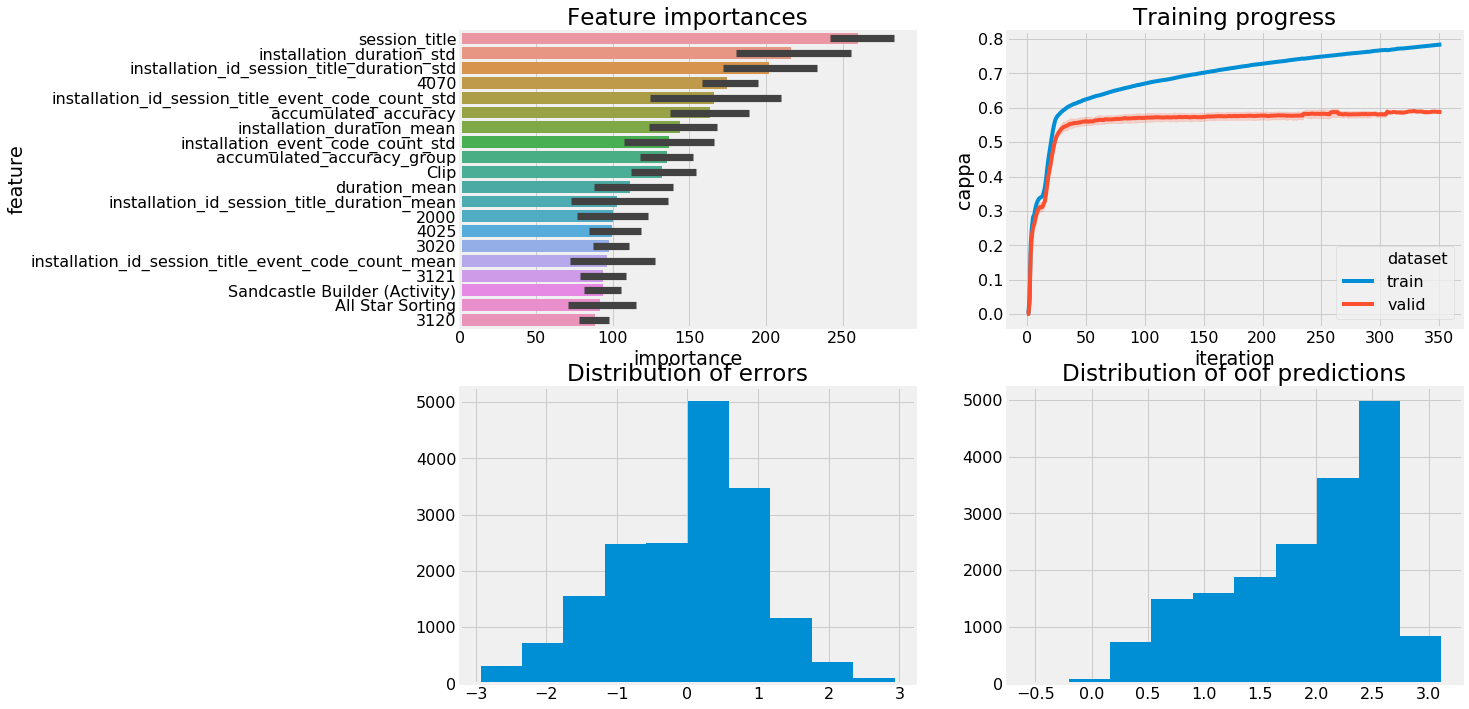

In [53]:
mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=reduce_train, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)


The OptimizedRounder class.

In [54]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [55]:
%%time
pr1 = regressor_model1.predict(reduce_train)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

CPU times: user 4.11 s, sys: 48 ms, total: 4.16 s
Wall time: 2.43 s


In [56]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

0.6644545924394629

In [57]:
# some coefficients calculated by me.
pr1 = regressor_model1.predict(reduce_test)
pr1[pr1 <= 1.12232214] = 0
pr1[np.where(np.logical_and(pr1 > 1.12232214, pr1 <= 1.73925866))] = 1
pr1[np.where(np.logical_and(pr1 > 1.73925866, pr1 <= 2.22506454))] = 2
pr1[pr1 > 2.22506454] = 3

In [58]:
sample_submission['accuracy_group'] = pr1.astype(int)
sample_submission.to_csv('submission.csv', index=False)

In [59]:
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2


**To be continued**